# Comparisons with Source Extractor object detection

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('..')
import descwl

## Load Simulations

In [3]:
LSST_i = descwl.output.Reader('../LSST_i_trimmed').results

In [4]:
DES_i = descwl.output.Reader('../DES_i_trimmed').results

## Match Detected Objects

In [5]:
LSST_i_match = LSST_i.match_sextractor('../LSST_i_noise.cat');

In [6]:
DES_i_match = DES_i.match_sextractor('../DES_i_noise.cat');

## Analysis

In [7]:
def completeness(cat,sample,estimator,snr_bins,**options):
    all_hist,bins = np.histogram(cat[estimator][sample],bins=snr_bins)
    found = np.logical_and(sample,cat['match']>=0)
    found_hist,bins = np.histogram(cat[estimator][found],bins=snr_bins)
    percent=np.zeros_like(all_hist)
    nonzero=(all_hist>0)
    percent[nonzero] = 100.*found_hist[nonzero]/all_hist[nonzero]
    snr_centers = 0.5*(snr_bins[:-1]+snr_bins[1:])
    plt.plot(snr_centers,percent,**options)

In [13]:
def analyze(results,match,isolation_cut=0.98,save=None):
    # Expand the tuple returned by match_sextractor()
    detected,matched,indices,distance = match
    print 'Matched %d of %d detected objects (median sep. = %.3f arcsecs).' % (
        np.count_nonzero(matched),len(matched),np.median(distance))
    # Lookup the results catalog and survey info.
    cat = results.table
    survey = results.survey
    # Calculate the simulated area in sq.arcmins.
    area = survey.image_width*survey.image_height*survey.pixel_scale**2/3600.
    print 'Simulated area = %.3f sq.arcmins.' % area
    area_wgt = np.empty_like(cat['snr_sky'])
    area_wgt[:] = 1/area
    # Only use sources with centroids within the area and snr_iso > 0.
    bad_snr = (cat['snr_iso']<=0.)
    print 'Dropped %d sources with snr_iso = 0 (max. snr_sky = %.3f)' % (
        np.count_nonzero(bad_snr),np.max(cat['snr_sky'][bad_snr]))
    visible = np.logical_and(np.logical_not(bad_snr),cat['visible']>0)
    num_visible = np.count_nonzero(visible)
    print 'Found %d visible sources (%.1f/sq.arcmin.)' % (num_visible,num_visible/area)
    # Define our 'blended' sample.
    blended = np.logical_and(visible,cat['purity'] < isolation_cut)
    num_blended = np.count_nonzero(blended)
    print 'Found %d blended sources (%.1f/sq.arcmin.) with purity < %.3f = %.1f%% of visible sources' % (
        num_blended,num_blended/area,isolation_cut,100.*num_blended/num_visible)
    isolated = np.logical_and(visible,np.logical_not(blended))
    num_isolated = np.count_nonzero(isolated)
    print 'Fraction of visible objects that are isolated is %.2f%%' % (100.*num_isolated/num_visible)
    # Calculate sextractor SNR using FLUX_AUTO.
    snr_auto = detected['FLUX_AUTO']/detected['FLUXERR_AUTO']
    # Initialize figure.
    fig = plt.figure(figsize=(15,4))
    nrow,ncol = 1,3
    #
    plt.subplot(nrow,ncol,1)
    nbins=80
    flo,fhi=0.2,1.8
    def ratiohist(cat,sample,snr_auto,estimator,**options):
        matched = (cat['match'][sample] >= 0)
        print 'Detected fraction is %.2f%%' % (100.* np.count_nonzero(matched)/np.count_nonzero(sample))
        ratio = snr_auto[cat['match'][sample][matched]]/cat[estimator][sample][matched]
        print 'Median snr_auto/snr_%s = %.3f' % (estimator,np.median(ratio))
        plt.hist(ratio,bins=nbins,range=(flo,fhi),weights=area_wgt[sample][matched],**options)
    ratiohist(cat,isolated,snr_auto,'snr_grpf',histtype='step',color='black',label='SE/grpf')
    ratiohist(cat,isolated,snr_auto,'snr_isof',histtype='step',color='red',label='SE/isof')
    ratiohist(cat,isolated,snr_auto,'snr_iso',histtype='step',color='blue',label='SE/iso')
    plt.xlim(flo,fhi)
    plt.xlabel('Ratio of signal-to-noise estimates')
    plt.ylabel('Detected galaxies / sq.arcmin. / bin')
    plt.legend()
    plt.annotate('(a) Isolated',xy=(0.35,0.9),xycoords='axes fraction',fontsize='large')
    #
    plt.subplot(nrow,ncol,2)
    ratiohist(cat,blended,snr_auto,'snr_grpf',histtype='step',color='black',label='SE/grpf')
    ratiohist(cat,blended,snr_auto,'snr_isof',histtype='step',color='red',label='SE/isof')
    ratiohist(cat,blended,snr_auto,'snr_iso',histtype='step',color='blue',label='SE/iso')
    plt.xlim(flo,fhi)
    plt.xlabel('Ratio of signal-to-noise estimates')
    plt.ylabel('Detected galaxies / sq.arcmin. / bin')
    plt.legend()
    plt.annotate('(b) Blended',xy=(0.35,0.9),xycoords='axes fraction',fontsize='large')
    #
    plt.subplot(nrow,ncol,3)
    snr_bins = np.linspace(0.,20.,20)
    w = visible
    completeness(cat,w,'snr_grpf',snr_bins,color='black',label='grpf')
    completeness(cat,w,'snr_isof',snr_bins,color='red',label='isof')
    completeness(cat,w,'snr_iso',snr_bins,color='blue',label='iso')
    w = isolated
    completeness(cat,w,'snr_grpf',snr_bins,color='black',linestyle='dashed')
    completeness(cat,w,'snr_isof',snr_bins,color='red',linestyle='dashed')
    completeness(cat,w,'snr_iso',snr_bins,color='blue',linestyle='dashed')
    w = blended
    completeness(cat,w,'snr_grpf',snr_bins,color='black',linestyle='dashdot')
    completeness(cat,w,'snr_isof',snr_bins,color='red',linestyle='dashdot')
    completeness(cat,w,'snr_iso',snr_bins,color='blue',linestyle='dashdot')
    plt.ylim(0,105)
    plt.xlabel('Signal-to-noise estimate')
    plt.ylabel('Detection rate (%)')
    plt.grid()
    plt.legend(loc='lower right')
    plt.annotate('(c)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # Finish up.
    plt.tight_layout();
    if save is not None:
        plt.savefig(save+'.pdf')
        plt.savefig(save+'.png')

Matched 13913 of 13913 detected objects (median sep. = 0.055 arcsecs).
Simulated area = 186.414 sq.arcmins.
Dropped 9 sources with snr_iso = 0 (max. snr_sky = 0.130)
Found 44984 visible sources (241.3/sq.arcmin.)
Found 25813 blended sources (138.5/sq.arcmin.) with purity < 0.980 = 57.4% of visible sources
Fraction of visible objects that are isolated is 42.62%
Detected fraction is 41.14%
Median snr_auto/snr_snr_grpf = 0.948
Detected fraction is 41.14%
Median snr_auto/snr_snr_isof = 0.907
Detected fraction is 41.14%
Median snr_auto/snr_snr_iso = 0.576
Detected fraction is 23.25%
Median snr_auto/snr_snr_grpf = 1.838
Detected fraction is 23.25%
Median snr_auto/snr_snr_isof = 1.009
Detected fraction is 23.25%
Median snr_auto/snr_snr_iso = 0.631


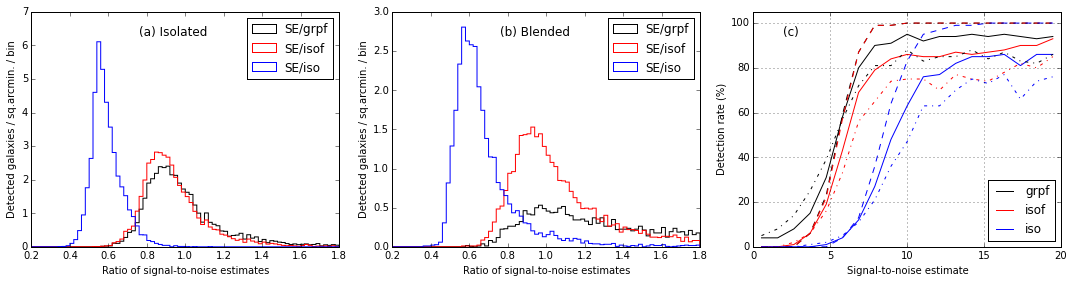

In [14]:
analyze(LSST_i,LSST_i_match,save='output/snr_detected')

Matched 4522 of 4522 detected objects (median sep. = 0.077 arcsecs).
Simulated area = 186.434 sq.arcmins.
Dropped 302 sources with snr_iso = 0 (max. snr_sky = 0.165)
Found 44094 visible sources (236.5/sq.arcmin.)
Found 20605 blended sources (110.5/sq.arcmin.) with purity < 0.980 = 46.7% of visible sources
Fraction of visible objects that are isolated is 53.27%
Detected fraction is 12.98%
Median snr_auto/snr_snr_grpf = 1.074
Detected fraction is 12.98%
Median snr_auto/snr_snr_isof = 1.000
Detected fraction is 12.98%
Median snr_auto/snr_snr_iso = 0.624
Detected fraction is 7.11%
Median snr_auto/snr_snr_grpf = 2.334
Detected fraction is 7.11%
Median snr_auto/snr_snr_isof = 1.139
Detected fraction is 7.11%
Median snr_auto/snr_snr_iso = 0.687


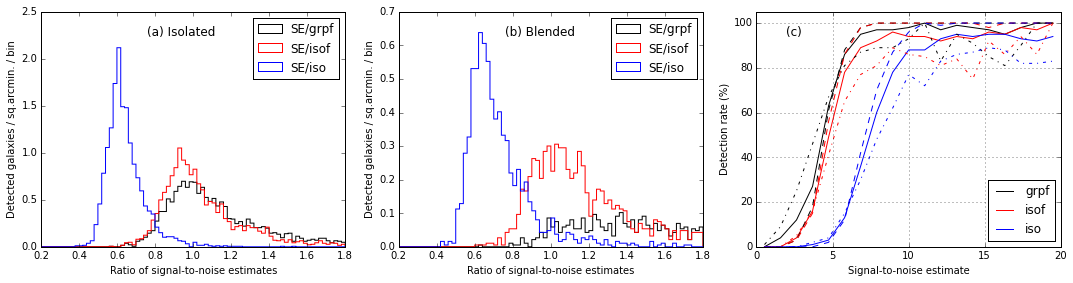

In [15]:
analyze(DES_i,DES_i_match)